In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.utils import resample
from scipy.cluster.hierarchy import linkage, dendrogram

# Load the dataset (assuming it's available as a CSV)
mcdonalds = pd.read_csv('D:/mcdonalds.csv')

# Display column names, dimensions, and first 3 rows
print(mcdonalds.columns)
print(mcdonalds.shape)
print(mcdonalds.head(3))

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [3]:
# Convert the first 11 columns to a numpy matrix and binarize
MD_x = mcdonalds.iloc[:, :11].values
MD_x = (MD_x == "Yes").astype(int)

# Calculate column means and round
col_means = np.round(np.mean(MD_x, axis=0), 2)
print(col_means)

[0.55 0.91 0.09 0.87 0.53 0.9  0.6  0.64 0.36 0.2  0.24]


In [4]:
# Perform PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# Summary of PCA
explained_variance_ratio = np.round(pca.explained_variance_ratio_, 2)
cumulative_explained_variance = np.round(np.cumsum(pca.explained_variance_ratio_), 2)
print("Explained Variance Ratio:", explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_explained_variance)

# Print PCA components with 1 digit precision
print(np.round(MD_pca, 1))

Explained Variance Ratio: [0.3  0.19 0.13 0.08 0.06 0.05 0.04 0.04 0.04 0.03 0.03]
Cumulative Explained Variance: [0.3  0.49 0.63 0.71 0.77 0.82 0.86 0.9  0.94 0.97 1.  ]
[[-0.4  0.2 -0.7 ... -0.2 -0.5  0.6]
 [ 0.2 -0.4  0.7 ... -0.1 -0.5  0.5]
 [-0.4 -0.7  0.1 ...  0.3 -0.1 -0.2]
 ...
 [ 0.2 -1.1 -0.2 ... -0.  -0.1  0. ]
 [ 1.2  0.  -0.6 ... -0.   0.   0.1]
 [-1.6 -0.3  0.  ...  0.1  0.4  0.5]]


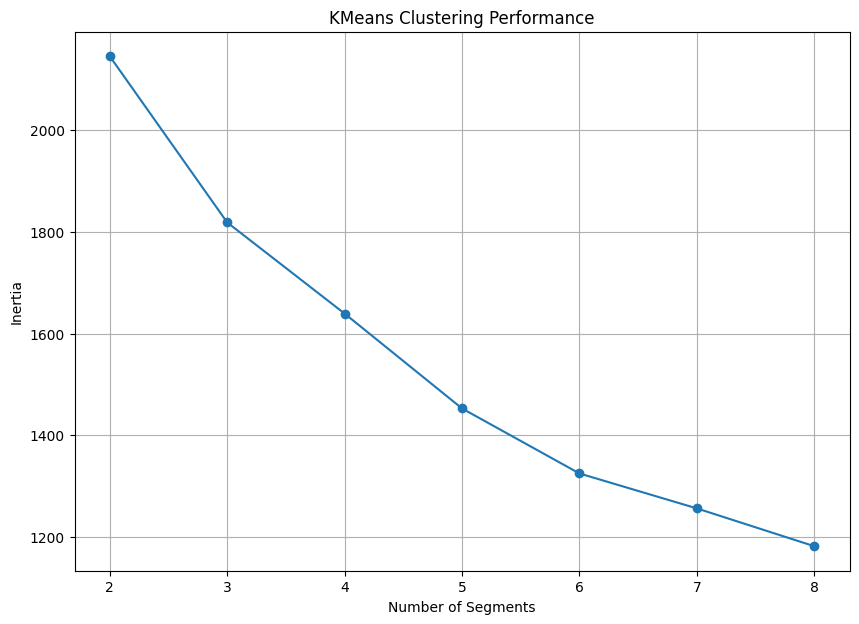

In [5]:
from sklearn.cluster import KMeans
import warnings
from sklearn.exceptions import ConvergenceWarning

# Set seed for reproducibility
np.random.seed(1234)

# Function to perform KMeans clustering for a range of cluster numbers
def step_kmeans(data, k_range, nrep=10):
    kmeans_results = {}
    for k in k_range:
        if len(data) < k:
            print(f"Skipping k={k} because the number of unique samples is less than the number of clusters.")
            continue
        best_kmeans = None
        best_inertia = float('inf')
        for _ in range(nrep):
            kmeans = KMeans(n_clusters=k, random_state=np.random.randint(0, 10000))
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                kmeans.fit(data)
                if len(np.unique(kmeans.labels_)) < k:
                    continue
                if kmeans.inertia_ < best_inertia:
                    best_kmeans = kmeans
                    best_inertia = kmeans.inertia_
        if best_kmeans:
            kmeans_results[k] = best_kmeans
    return kmeans_results

# Perform KMeans clustering
k_range = range(2, 9)
MD_km28 = step_kmeans(MD_x, k_range, nrep=10)

# Function to plot KMeans results
def plot_kmeans_results(kmeans_results):
    inertia_values = [kmeans.inertia_ for kmeans in kmeans_results.values()]
    plt.figure(figsize=(10, 7))
    plt.plot(list(kmeans_results.keys()), inertia_values, marker='o')
    plt.xlabel('Number of Segments')
    plt.ylabel('Inertia')
    plt.title('KMeans Clustering Performance')
    plt.grid(True)
    plt.show()

# Plot KMeans results
plot_kmeans_results(MD_km28)

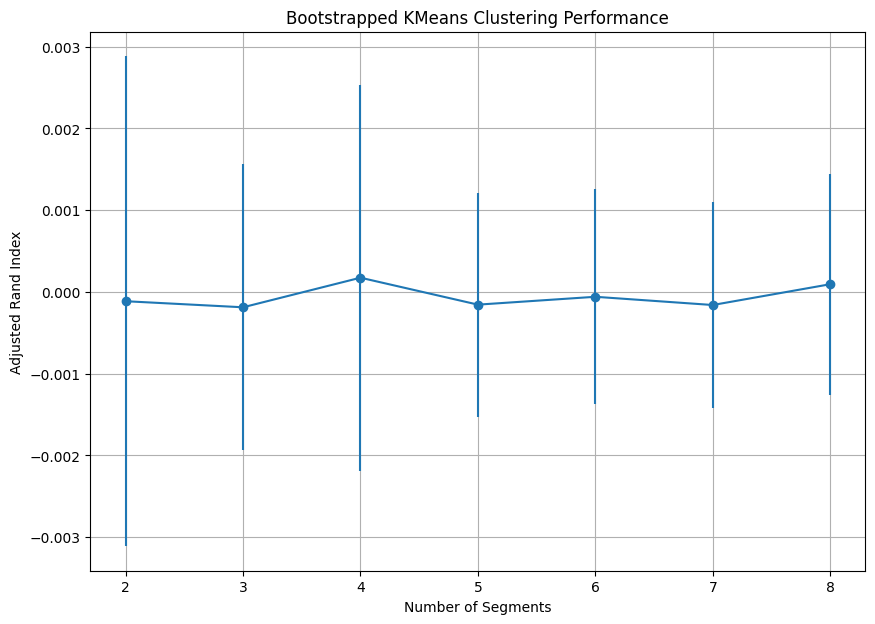

In [7]:
from sklearn.metrics import adjusted_rand_score

# Function to perform bootstrapping and calculate ARI
def boot_kmeans(data, k_range, nrep=10, nboot=100):
    best_kmeans = {}
    all_kmeans = []
    for k in k_range:
        if len(data) < k:
            print(f"Skipping k={k} because the number of unique samples is less than the number of clusters.")
            continue
        best_local_kmeans = None
        best_local_inertia = float('inf')
        for _ in range(nrep):
            kmeans = KMeans(n_clusters=k, random_state=np.random.randint(0, 10000))
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                kmeans.fit(data)
                if len(np.unique(kmeans.labels_)) < k:
                    continue
                all_kmeans.append(kmeans)
                if kmeans.inertia_ < best_local_inertia:
                    best_local_kmeans = kmeans
                    best_local_inertia = kmeans.inertia_
        boot_ari = []
        for _ in range(nboot):
            boot_sample = resample(data, random_state=np.random.randint(0, 10000))
            kmeans_boot = KMeans(n_clusters=k, random_state=np.random.randint(0, 10000))
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)
                kmeans_boot.fit(boot_sample)
                ari = adjusted_rand_score(best_local_kmeans.labels_, kmeans_boot.labels_)
                boot_ari.append(ari)
        best_kmeans[k] = {'best_kmeans': best_local_kmeans, 'boot_ari': boot_ari}
    return best_kmeans

# Perform bootstrapping
MD_b28 = boot_kmeans(MD_x, k_range, nrep=10, nboot=100)

# Plot bootstrapped results
k_values = []
mean_ari = []
std_ari = []
for k in k_range:
    if k in MD_b28:
        k_values.append(k)
        ari_values = MD_b28[k]['boot_ari']
        mean_ari.append(np.mean(ari_values))
        std_ari.append(np.std(ari_values))

plt.figure(figsize=(10, 7))
plt.errorbar(k_values, mean_ari, yerr=std_ari, fmt='-o')
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Bootstrapped KMeans Clustering Performance')
plt.grid(True)
plt.show()

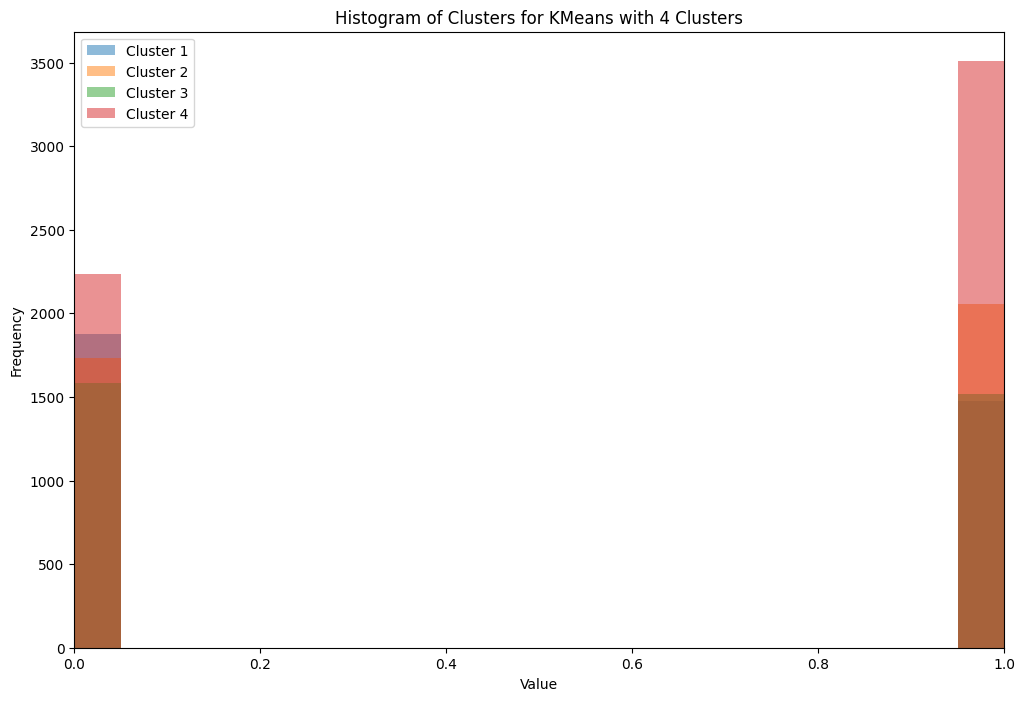

In [8]:
MD_k4 = MD_km28.get(4, None)
if MD_k4:
    labels_4 = MD_k4.labels_
    plt.figure(figsize=(12, 8))
    for cluster in range(4):
        cluster_data = MD_x[labels_4 == cluster]
        plt.hist(cluster_data.flatten(), bins=20, alpha=0.5, label=f'Cluster {cluster + 1}')
    plt.xlim(0, 1)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram of Clusters for KMeans with 4 Clusters')
    plt.legend()
    plt.show()

In [9]:
from sklearn.metrics import silhouette_score, silhouette_samples

if MD_k4:
    labels_4 = MD_k4.labels_
    silhouette_avg = silhouette_score(MD_x, labels_4)
    sample_silhouette_values = silhouette_samples(MD_x, labels_4)
    MD_r4 = {'silhouette_avg': silhouette_avg, 'sample_silhouette_values': sample_silhouette_values}
    print("MD_r4:", MD_r4)

MD_r4: {'silhouette_avg': 0.2387149382447963, 'sample_silhouette_values': array([0.16904255, 0.06533818, 0.14114634, ..., 0.34792514, 0.33133555,
       0.31171402])}


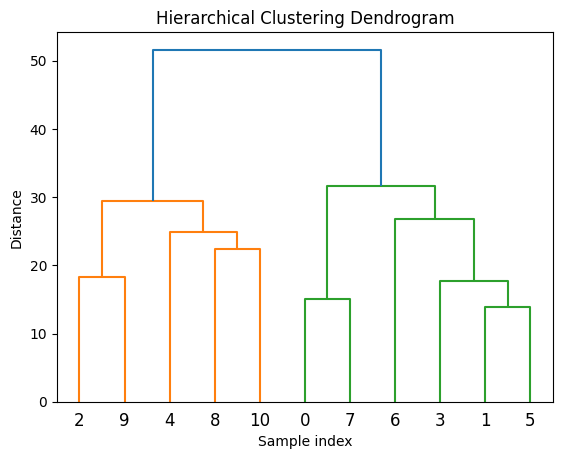

In [11]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

MD_vclust = linkage(pdist(MD_x.T), method='ward')
dendrogram(MD_vclust)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

C:\Users\AB\AppData\Local\Temp\ipykernel_7960\3093860252.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=cluster_df, palette='viridis')


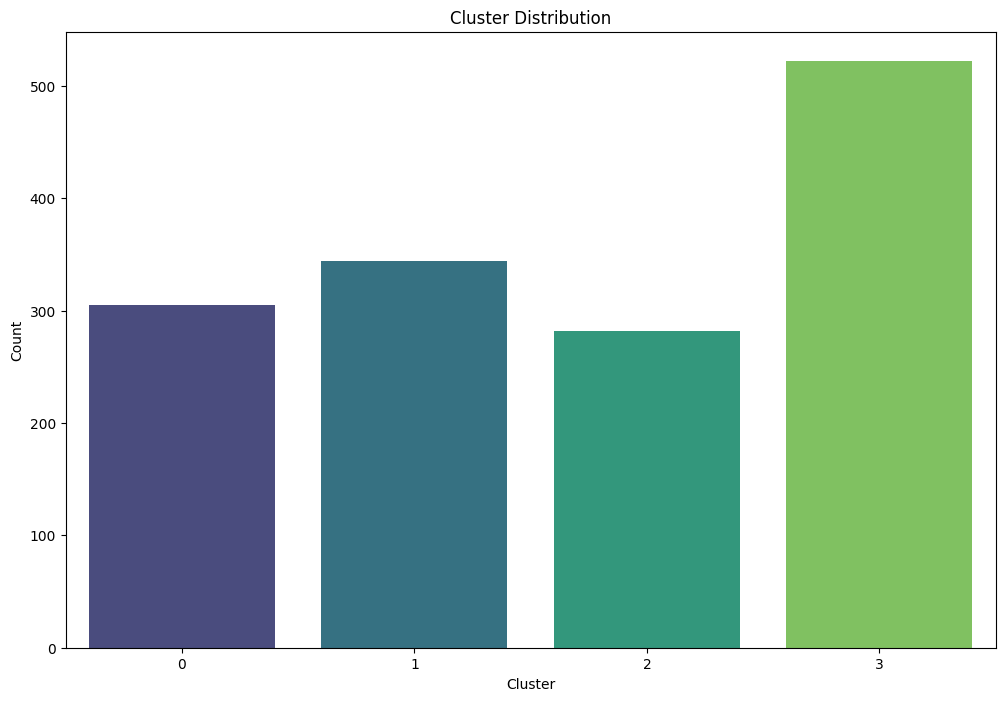

In [13]:
import seaborn as sns

# Assuming MD_k4 is the KMeans object with 4 clusters and MD_vclust is the linkage matrix
labels_4 = MD_k4.labels_

# Create a DataFrame for clustering results
cluster_df = pd.DataFrame(MD_x, columns=mcdonalds.columns[:11])
cluster_df['cluster'] = labels_4

# Plot barchart
plt.figure(figsize=(12, 8))
sns.countplot(x='cluster', data=cluster_df, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

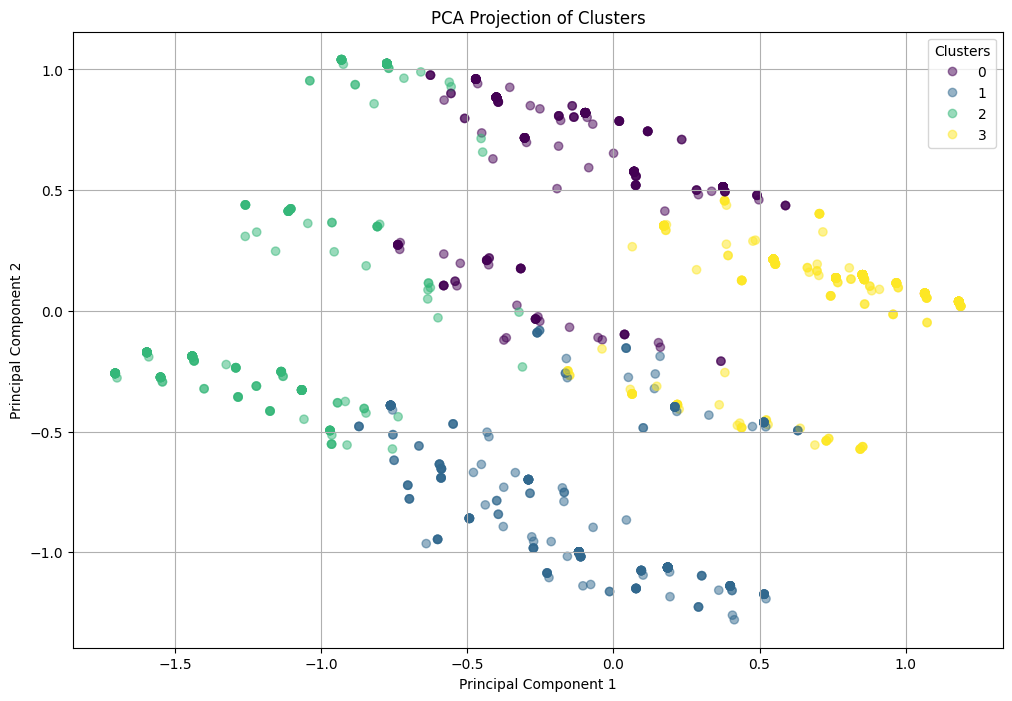

In [14]:
# Project data into PCA space
pca_components = pca.transform(MD_x)
labels_4 = MD_k4.labels_

plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels_4, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Clusters')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

<Figure size 1200x800 with 0 Axes>

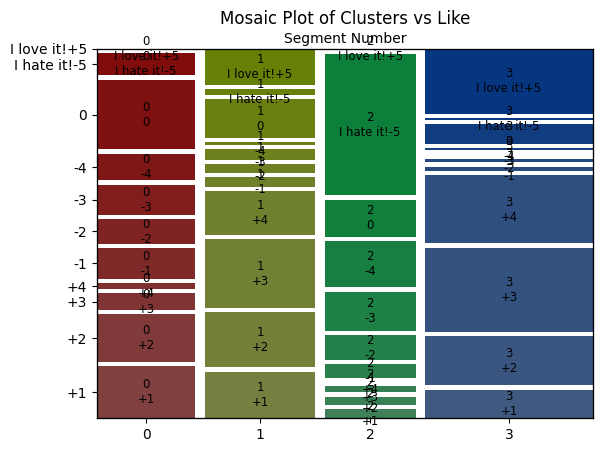

<Figure size 1200x800 with 0 Axes>

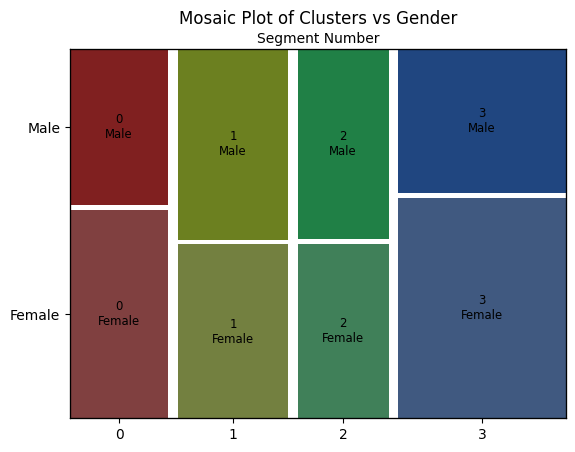

In [16]:
from statsmodels.graphics.mosaicplot import mosaic

k4 = MD_k4.labels_

# Convert to categorical data for mosaic plot
like_table = pd.crosstab(k4, mcdonalds['Like'])
gender_table = pd.crosstab(k4, mcdonalds['Gender'])

# Mosaic plot for Like
plt.figure(figsize=(12, 8))
mosaic(like_table.stack(), title='Mosaic Plot of Clusters vs Like', gap=0.02)
plt.xlabel('Segment Number')
plt.show()

# Mosaic plot for Gender
plt.figure(figsize=(12, 8))
mosaic(gender_table.stack(), title='Mosaic Plot of Clusters vs Gender', gap=0.02)
plt.xlabel('Segment Number')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Convert categorical variables to numeric for decision tree
mcdonalds['Gender'] = mcdonalds['Gender'].apply(lambda x: 1 if x == 'Female' else 0)
mcdonalds['k4'] = k4
mcdonalds['Like.n'] = 6 - mcdonalds['Like'].astype('category').cat.codes

# Define features and target
features = ['Like.n', 'Age', 'VisitFrequency', 'Gender']
target = 'k4'
X = mcdonalds[features]
y = (mcdonalds['k4'] == 3).astype(int)

# Train decision tree classifier
clf = DecisionTreeClassifier(random_state=1234)
clf = clf.fit(X, y)

# Plot decision tree
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=features, class_names=['Not 3', '3'], filled=True, rounded=True)
plt.show()

In [ ]:
visit = mcdonalds.groupby('k4')['VisitFrequency'].mean()
like = mcdonalds.groupby('k4')['Like.n'].mean()
female = mcdonalds.groupby('k4')['Gender'].mean()

# Plot results
plt.figure(figsize=(12, 8))
plt.scatter(visit, like, s=1000 * female, alpha=0.5)
for i, txt in enumerate(visit.index):
    plt.text(visit[txt], like[txt], str(txt), fontsize=12, ha='center', va='center')
plt.xlabel('Visit Frequency')
plt.ylabel('Like')
plt.xlim(2, 4.5)
plt.ylim(-3, 3)
plt.title('Visit Frequency vs Like by Cluster')
plt.grid(True)
plt.show()